In [15]:
using JLD2
using FileIO
using LinearAlgebra
using Plots
using Dierckx
using LinearAlgebra
using LaTeXStrings
using Meshfree4ScalarEq.ScalarHyperbolicEquations
using Meshfree4ScalarEq.ParticleGrids
using Meshfree4ScalarEq.TimeIntegration
using Meshfree4ScalarEq.Interpolations
using Meshfree4ScalarEq.SimSettings
using Meshfree4ScalarEq
# plotlyjs()

In [16]:
function mapGrid(x, xmin, xmax)
    temp = x .- xmin
    temp1 = mod.(temp, xmax-xmin)
    return temp1 .+ xmin
end;

function smoothInit(x::Real, y::Real)
    return exp(-x^2 - y^2)
end;

function shockInit(x::Real, y::Real)
    return (-0.5 < x < 0.5) && (-0.5 < y < 0.5) ? 1.0 : 0.0
end;

In [17]:
function computeError(particleGrid::ParticleGrid2D, initFunc::Function, time::Real, vel::Tuple{Float64, Float64}; normP = 2)    
    rhosReduced = collect(map(particle -> particle.rho, particleGrid.grid))
    xsIrregularReduced = collect(map(particle -> particle.pos, particleGrid.grid))
    
    exactSol = zeros(length(xsIrregularReduced))
    for (index, (x, y)) in enumerate(xsIrregularReduced)
        exactSol[index] = initFunc(mapGrid(x - vel[1]*time, particleGrid.xmin, particleGrid.xmax), mapGrid(y - vel[2]*time, particleGrid.ymin, particleGrid.ymax))
    end

    # Return absolute error
    return norm(exactSol - rhosReduced, normP)/norm(exactSol, normP)
end;

In [18]:
folder = "$(@__DIR__)/data/";
a = (1.0, 1.0);
tmax = 1.0;
Algorithms = ["MeshfreeUpwind1" "RK3WENO2" "RK3MOODUpwind2" "RK3MUSCL2" "RK3MOODMUSCL2" "RK3MOODMUSCL1"];
labels = ["Upwind: order 1"; "WENO: order 2"; "Upwind + MOOD: order 2"; "MUSCL 2"; "MUSCL + MOOD: order 2"; "MUSCL + MOOD: order 1"];

In [19]:
d1 = load(folder*"timingResults_smoothInit.jld2");
d2 = load(folder*"timingResults_shockInit.jld2");

Ns = d1["Ns"];
algsNumber = d1["Algs"];
timingsSmooth = reshape(d1["pmapRes"], (length(algsNumber), length(Ns)));
timingsShock = reshape(d2["pmapRes"], (length(algsNumber), length(Ns)));

In [20]:
errorsSmooth = zeros((length(Ns), length(Algorithms)))
for file in readdir(folder)
    if isdir(folder*file)
        Alg, _, _, N = split(file, "_")
        N = parse(Float64, N)
        if (N in Ns) && contains(file, "smoothInit") && (Alg in Algorithms)
            algIndex = findfirst(x -> x == Alg, Algorithms)[2]
            NIndex = findfirst(x -> x == N, Ns)
            
            # Find final simulation file
            maxNb = maximum(map(file -> parse(Int64, file[5:end-5]), readdir(folder*file*"/data/")[2:end]))

            # Load grid and compute error
            # println(folder*file*"/data/step$(maxNb).jld2")
            particleGrid = load(folder*file*"/data/step$(maxNb).jld2")["particleGrid"]
            errorsSmooth[NIndex, algIndex] = computeError(particleGrid, smoothInit, tmax, a)
        end
    end
end

In [21]:
timingsSmooth

7×6 Matrix{Float64}:
 0.0867493  0.276696   7.27777  23.2815   54.58    147.238
 0.843503   2.96063   18.6466   38.0902  142.877   478.8
 0.428565   1.76058   15.4756   35.5466  111.299   341.555
 0.359345   1.14669   12.5489   27.5496   80.9113  260.065
 0.598624   2.47348   18.107    36.8116  141.368   406.897
 0.472491   1.42285   16.4832   33.4979  110.868   287.861
 0.675615   2.81435   19.5455   41.2615  152.94    451.726

In [22]:
timingsSmooth[6, :]./timingsSmooth[5, :]

6-element Vector{Float64}:
 0.7892947560319404
 0.5752434826646736
 0.9103236871364545
 0.9099817202670752
 0.7842486915911907
 0.7074548923615833

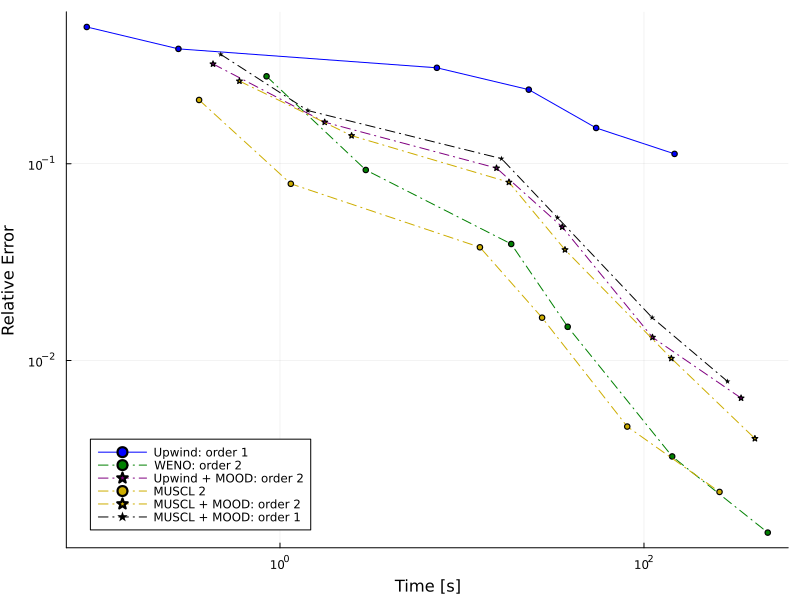

"/scratch/cac13ruw/meshfree4hypeq/numericalExperiments/algorithmEfficiency2D/efficiencySmooth.pdf"

In [23]:
ms = 3;
p3 = plot(timingsSmooth[1, :], errorsSmooth[:, 1], xscale=:log10, yscale=:log10, label=labels[1], legend=:bottomleft, ylabel="Relative Error", xlabel="Time [s]", ls=:solid, markershape=:circle, markersize=ms, size=(800, 600), c=:blue)
plot!(p3, timingsSmooth[2, :], errorsSmooth[:, 2], xscale=:log10, yscale=:log10, label=labels[2], ls=:dashdot, markershape=:circle, markersize=ms, c=:green)
plot!(p3, timingsSmooth[3, :], errorsSmooth[:, 3], xscale=:log10, yscale=:log10, label=labels[3], ls=:dashdot, markershape=:star, markersize=ms, c=:purple)
plot!(p3, timingsSmooth[4, :], errorsSmooth[:, 4], xscale=:log10, yscale=:log10, label=labels[4], ls=:dashdot, markershape=:circle, markersize=ms, c=:gold3)
plot!(p3, timingsSmooth[5, :], errorsSmooth[:, 5], xscale=:log10, yscale=:log10, label=labels[5], ls=:dashdot, markershape=:star, markersize=ms, c=:gold3)
plot!(p3, timingsSmooth[6, :], errorsSmooth[:, 6], xscale=:log10, yscale=:log10, label=labels[6], ls=:dashdot, markershape=:star, markersize=ms, c=:black)
display(p3)
savefig(p3, "$(@__DIR__)/efficiencySmooth.pdf")

In [24]:
pgrid = load("/scratch/cac13ruw/meshfree4hypeq/numericalExperiments/algorithmEfficiency2D/data/RK3MOODMUSCL2_irgrid_smoothInit_250/data/step2.jld2")["particleGrid"]
for particle in pgrid.grid
    if particle.moodEvent
        println(particle.pos)
    end
end

d = maximum((particle.volume for particle in pgrid.grid))

(0.40439787846199937, 0.47406986852256955)
(0.40924261540152523, 0.4932683387930008)
(0.4235725332297141, 0.5355782604072904)
(0.46832890958774437, 0.42636087589327043)
(0.45627607579834667, 0.46287254755885887)
(0.45518791567300265, 0.4887190368689191)
(0.44045386419787186, 0.5279689079811956)
(0.4816540763838845, 0.4158960626486892)
(0.49088232783201724, 0.44548705246368325)
(0.49929628240635043, 0.5031151153245134)
(0.4982019906477916, 0.5345313266731233)
(0.5368141152173496, 0.4246843603295555)
(0.5386450899895054, 0.45056880675833766)
(0.5215849656759874, 0.5254670736560627)


0.007465058386231821

In [25]:
errorsShock = zeros((length(Ns), length(Algorithms)))
for file in readdir(folder)
    if isdir(folder*file)
        Alg, _, _, N = split(file, "_")
        N = parse(Float64, N)
        if (N in Ns) && contains(file, "shockInit") && (Alg in Algorithms)
            algIndex = findfirst(x -> x == Alg, Algorithms)[2]
            NIndex = findfirst(x -> x == N, Ns)

            # Find final simulation file
            maxNb = maximum(map(file -> parse(Int64, file[5:end-5]), readdir(folder*file*"/data/")[2:end]))

            # Load grid and compute error
            particleGrid = load(folder*file*"/data/step$(maxNb).jld2")["particleGrid"]
            errorsShock[NIndex, algIndex] = computeError(particleGrid, shockInit, tmax, a)
        end
    end
end

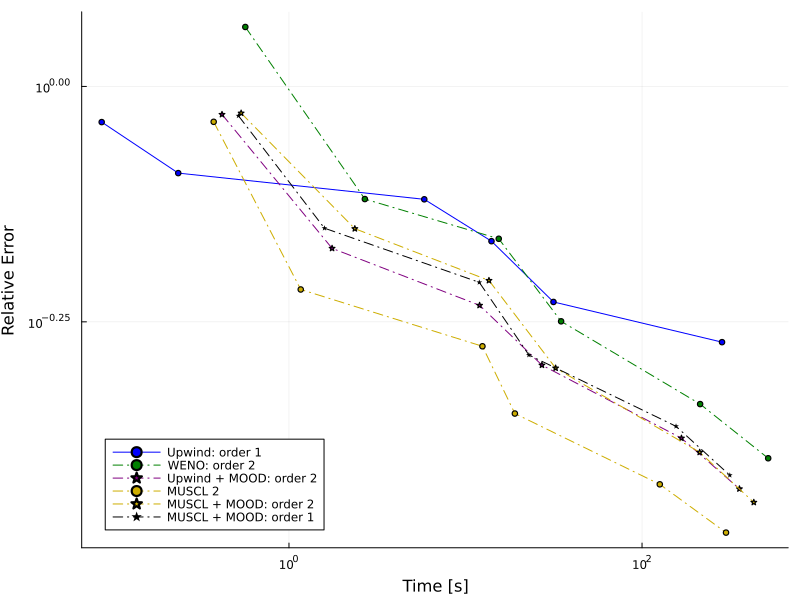

"/scratch/cac13ruw/meshfree4hypeq/numericalExperiments/algorithmEfficiency2D/efficiencyShock.pdf"

In [26]:
p4 = plot(timingsShock[1, :], errorsShock[:, 1], xscale=:log10, yscale=:log10, label=labels[1], legend=:bottomleft, ylabel="Relative Error", xlabel="Time [s]", ls=:solid, markershape=:circle, markersize=ms, size=(800, 600), c=:blue)
plot!(p4, timingsShock[2, :], errorsShock[:, 2], xscale=:log10, yscale=:log10, label=labels[2], ls=:dashdot, markershape=:circle, markersize=ms, c=:green)
plot!(p4, timingsShock[3, :], errorsShock[:, 3], xscale=:log10, yscale=:log10, label=labels[3], ls=:dashdot, markershape=:star, markersize=ms, c=:purple)
plot!(p4, timingsShock[4, :], errorsShock[:, 4], xscale=:log10, yscale=:log10, label=labels[4], ls=:dashdot, markershape=:circle, markersize=ms, c=:gold3)
plot!(p4, timingsShock[5, :], errorsShock[:, 5], xscale=:log10, yscale=:log10, label=labels[5], ls=:dashdot, markershape=:star, markersize=ms, c=:gold3)
plot!(p4, timingsShock[6, :], errorsShock[:, 6], xscale=:log10, yscale=:log10, label=labels[6], ls=:dashdot, markershape=:star, markersize=ms, c=:black)
display(p4)
savefig(p4, "$(@__DIR__)/efficiencyShock.pdf")